Лабораторная работа №3. Алгоритм k-средних (K-Means) на датасете Wine

Курс: «Методы принятия решений и машинное обучение»
Студент: Москвитин М.К., 221-321


=== ОПИСАНИЕ ДАТАСЕТА WINE ===
Форма X: (178, 13) (объектов, признаков)
Форма y: (178,)

Типы признаков:
alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object

Первые 5 строк данных:
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50 

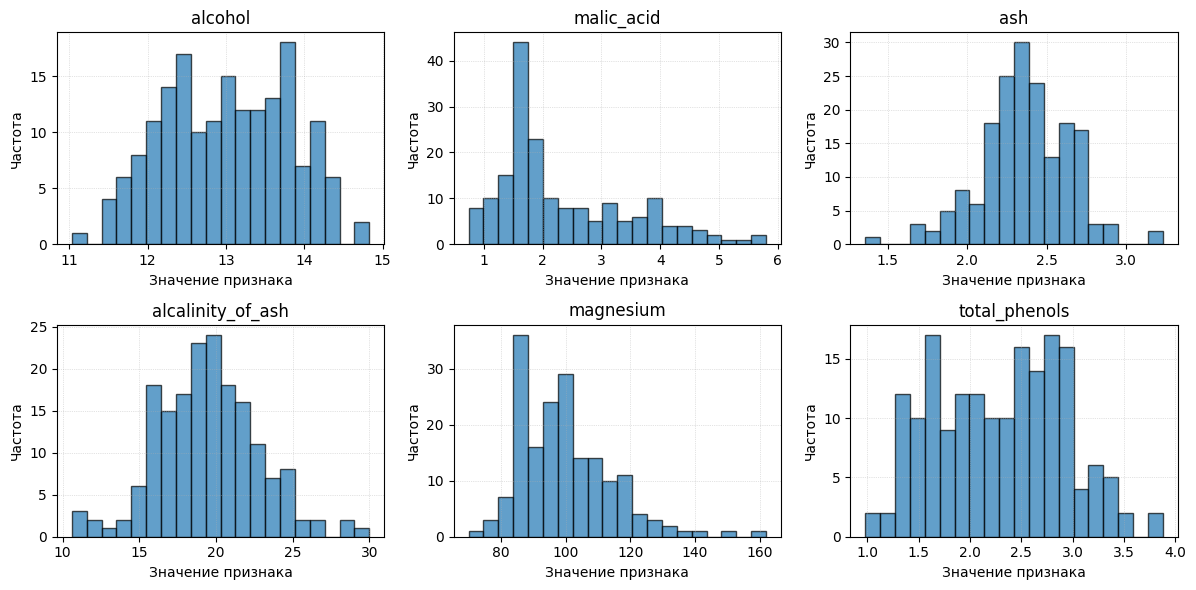

Используем StandardScaler: центрирование и нормировка до единичного std.
Масштабирование завершено.

=== ПОДБОР ЧИСЛА КЛАСТЕРОВ k ===
Диапазон k: [2, 3, 4, 5, 6, 7, 8, 9, 10]
n_init = 20, max_iter = 300, random_state = 42

Обучаем KMeans с k = 2...
  inertia = 1658.76, silhouette = 0.2593, Davies–Bouldin = 1.5260, Calinski–Harabasz = 69.52, ARI = 0.3743, NMI = 0.4782
Обучаем KMeans с k = 3...
  inertia = 1277.93, silhouette = 0.2849, Davies–Bouldin = 1.3892, Calinski–Harabasz = 70.94, ARI = 0.8975, NMI = 0.8759
Обучаем KMeans с k = 4...
  inertia = 1175.35, silhouette = 0.2586, Davies–Bouldin = 1.8170, Calinski–Harabasz = 56.19, ARI = 0.7646, NMI = 0.8117
Обучаем KMeans с k = 5...
  inertia = 1107.01, silhouette = 0.2315, Davies–Bouldin = 1.6811, Calinski–Harabasz = 47.16, ARI = 0.6472, NMI = 0.7007
Обучаем KMeans с k = 6...
  inertia = 1046.00, silhouette = 0.2372, Davies–Bouldin = 1.5544, Calinski–Harabasz = 41.70, ARI = 0.6391, NMI = 0.7023
Обучаем KMeans с k = 7...
  inertia = 981.

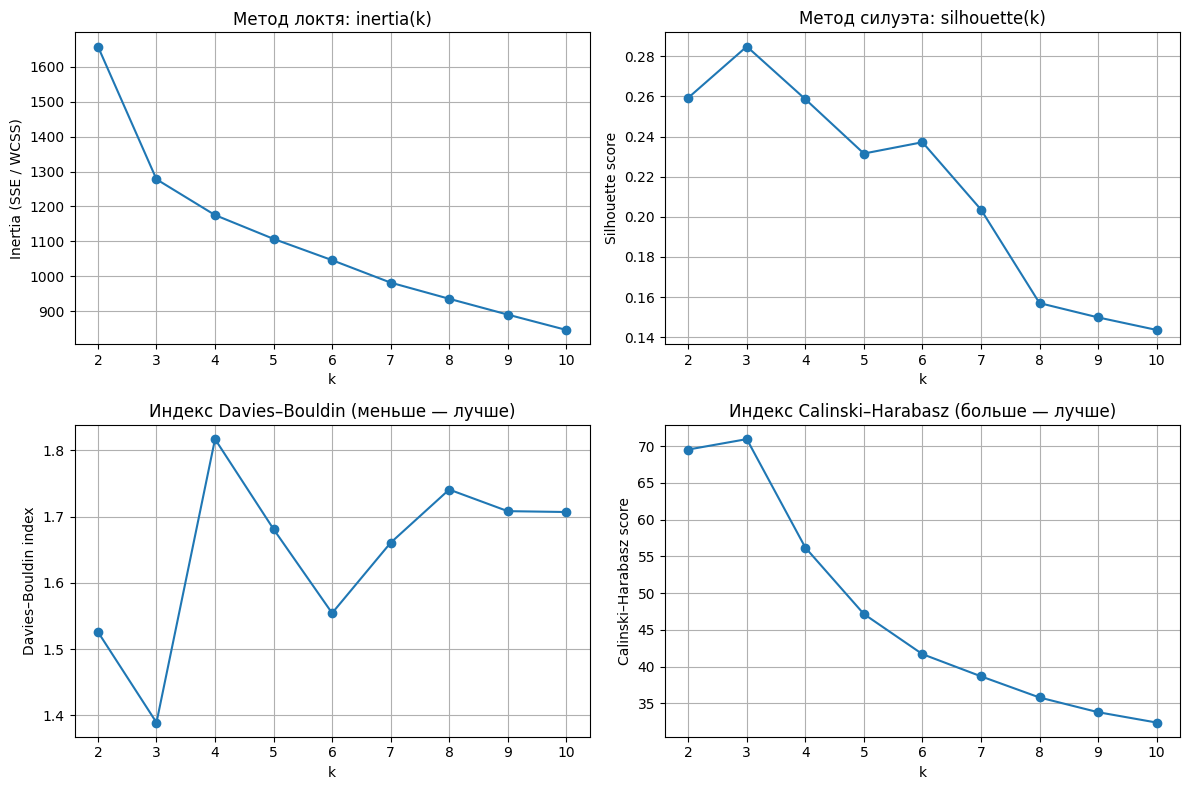

=== СРАВНЕНИЕ МЕТОДОВ ВЫБОРА k ===
Лучший k по silhouette:          k = 3
Лучший k по Calinski–Harabasz:  k = 3
Лучший k по Davies–Bouldin:     k = 3

Итоговый выбор k на основе метрик: k = 3
(при оформлении отчёта можно дополнительно обсуждать локоть по inertia.)

=== ФИНАЛЬНАЯ МОДЕЛЬ ДЛЯ ВЫБРАННОГО k ===
Число кластеров: k = 3
Inertia (SSE / WCSS):    1277.93
Silhouette score:        0.2849
Davies–Bouldin index:    1.3892
Calinski–Harabasz score: 70.94
Adjusted Rand Index:     0.8975
Normalized MI (NMI):     0.8759

=== АНАЛИЗ СТАБИЛЬНОСТИ ДЛЯ k = 3 ===
Число запусков: 20

Запуск  0 (random_state = 42): inertia = 1277.93, silhouette = 0.2849, Davies–Bouldin = 1.3892, Calinski–Harabasz = 70.94, ARI = 0.8975, NMI = 0.8759
Запуск  1 (random_state = 43): inertia = 1278.76, silhouette = 0.2859, Davies–Bouldin = 1.3918, Calinski–Harabasz = 70.84, ARI = 0.9149, NMI = 0.8926
Запуск  2 (random_state = 44): inertia = 1282.46, silhouette = 0.2807, Davies–Bouldin = 1.3931, Calinski–Harabasz = 70

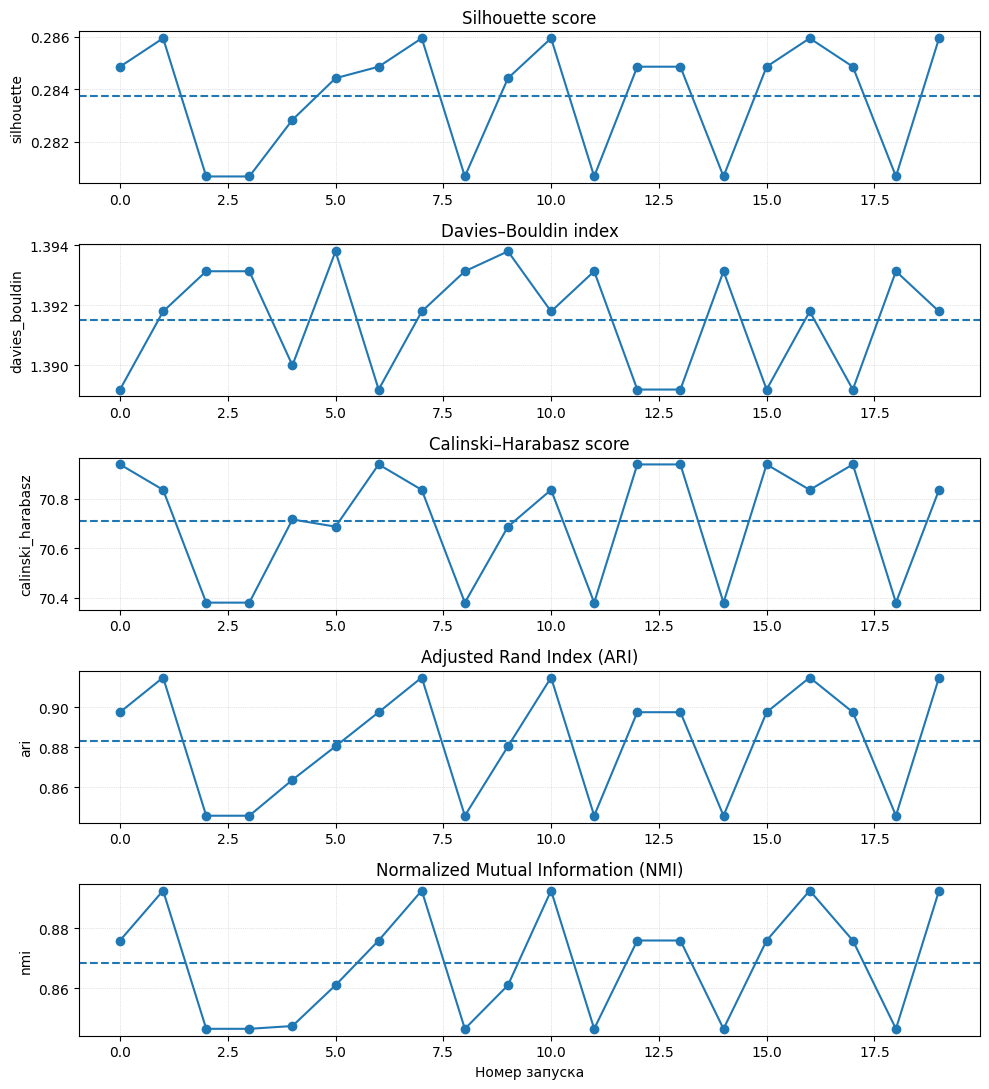

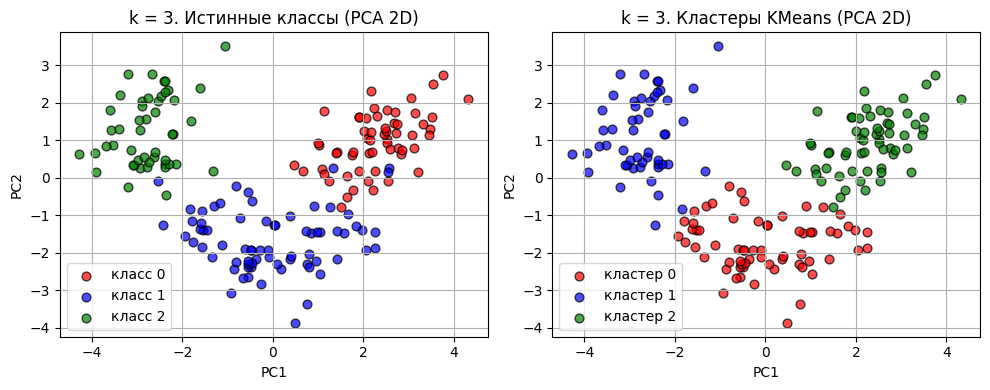

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)
from sklearn.decomposition import PCA


# ==========================
# НАСТРОЙКИ ЭКСПЕРИМЕНТА
# ==========================

RANDOM_SEED = 42

# Диапазон значений k, который будем проверять
K_RANGE = range(2, 11)

# Количество случайных инициализаций центроидов для каждого k
N_INIT_FOR_SELECTION = 20

# Максимальное число итераций для KMeans
MAX_ITER = 300

# Количество запусков для анализа стабильности
N_STABILITY_RUNS = 20


# ==========================
# ЗАГРУЗКА И ОПИСАНИЕ ДАННЫХ
# ==========================

def load_wine_dataset(as_frame: bool = True):
    """
    Загружает датасет Wine из sklearn и возвращает (X, y, feature_names, target_names).

    Parameters
    ----------
    as_frame : bool
        Если True, X возвращается как pandas.DataFrame.

    Returns
    -------
    X : pandas.DataFrame или numpy.ndarray
        Матрица признаков.
    y : numpy.ndarray
        Вектор меток классов.
    feature_names : list[str]
        Список названий признаков.
    target_names : list[str]
        Список названий классов (сортов вина).
    """
    data = load_wine(as_frame=as_frame)

    X = data.data
    y = data.target
    feature_names = list(data.feature_names)
    target_names = list(data.target_names)

    if as_frame:
        # На всякий случай делаем копию, чтобы не портить исходный объект
        X = X.copy()

    return X, y, feature_names, target_names


def detect_outliers_iqr(X: pd.DataFrame, iqr_factor: float = 1.5) -> dict:
    """
    Простейший поиск выбросов по правилу "квартильного размаха" (IQR).

    Для каждого признака считаем:
        IQR = Q3 - Q1
        нижняя граница = Q1 - iqr_factor * IQR
        верхняя граница = Q3 + iqr_factor * IQR
    и считаем количество объектов, выходящих за эти границы.

    Returns
    -------
    outliers_per_feature : dict
        Словарь {имя_признака: число_объектов_с_выбросами}.
    """
    outliers_per_feature = {}

    for col in X.columns:
        series = X[col]
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1

        if iqr == 0:
            # Признак почти константный – выбросами в таком простом подходе
            # мы его не считаем
            outliers_per_feature[col] = 0
            continue

        lower = q1 - iqr_factor * iqr
        upper = q3 + iqr_factor * iqr
        mask = (series < lower) | (series > upper)
        outliers_per_feature[col] = int(mask.sum())

    return outliers_per_feature


def describe_wine_dataset(X: pd.DataFrame, y: np.ndarray) -> None:
    """
    Печатает основные характеристики датасета Wine
    и показывает базовые сведения о распределении признаков.
    """
    print("=== ОПИСАНИЕ ДАТАСЕТА WINE ===")
    print(f"Форма X: {X.shape} (объектов, признаков)")
    print(f"Форма y: {y.shape}")
    print()

    print("Типы признаков:")
    print(X.dtypes)
    print()

    print("Первые 5 строк данных:")
    print(X.head())
    print()

    print("Статистика по признакам (describe):")
    print(X.describe())
    print()

    # Проверка дубликатов
    num_duplicates_features = int(X.duplicated().sum())
    print(f"Число полностью совпадающих строк по X (дубликатов): {num_duplicates_features}")

    # Проверка дубликатов по (X, y) — иногда полезно понимать, есть ли полностью одинаковые объекты
    df_full = X.copy()
    df_full["target"] = y
    num_duplicates_full = int(df_full.duplicated().sum())
    print(f"Число полностью совпадающих объектов (X + y): {num_duplicates_full}")
    print()

    # Элементарный анализ выбросов по IQR
    print("Число потенциальных выбросов по признакам (IQR * 1.5):")
    outliers = detect_outliers_iqr(X, iqr_factor=1.5)
    for feature, count in outliers.items():
        print(f"  {feature:25s}: {count:3d}")
    print()

    # Распределение целевого класса
    unique, counts = np.unique(y, return_counts=True)
    print("Распределение классов (сортов вина):")
    for label, cnt in zip(unique, counts):
        print(f"  класс {label}: {cnt} объектов")
    print()


def plot_feature_distributions(X: pd.DataFrame, max_features: int = 6) -> None:
    """
    Рисует гистограммы нескольких первых признаков датасета Wine.

    Для отчёта достаточно показать распределение небольшого поднабора признаков.
    """
    n_features = min(max_features, X.shape[1])
    cols = list(X.columns[:n_features])

    n_rows = int(np.ceil(n_features / 3))
    n_cols = min(3, n_features)

    plt.figure(figsize=(4 * n_cols, 3 * n_rows))

    for idx, col in enumerate(cols, start=1):
        plt.subplot(n_rows, n_cols, idx)
        plt.hist(X[col], bins=20, edgecolor="black", alpha=0.7)
        plt.title(col)
        plt.xlabel("Значение признака")
        plt.ylabel("Частота")
        plt.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()


# ==========================
# ПРЕДОБРАБОТКА ДАННЫХ
# ==========================

def scale_features(X: pd.DataFrame,
                   scaler_type: str = "standard"):
    """
    Масштабирует признаки для алгоритма k-средних.

    Для k-средних важно, чтобы все признаки были в сопоставимых масштабах,
    так как алгоритм использует евклидово расстояние.

    Parameters
    ----------
    X : pandas.DataFrame
        Матрица признаков.
    scaler_type : {"standard", "minmax"}
        Тип масштабирования:
          - "standard" : StandardScaler (обнуляет среднее, делит на std)
          - "minmax"   : MinMaxScaler (линейно приводит к [0, 1])

    Returns
    -------
    X_scaled : numpy.ndarray
        Масштабированные признаки.
    scaler : StandardScaler или MinMaxScaler
        Обученный масштабировщик (на случай, если понадобится восстановление).
    """
    if scaler_type == "standard":
        scaler = StandardScaler()
        print("Используем StandardScaler: центрирование и нормировка до единичного std.")
    elif scaler_type == "minmax":
        scaler = MinMaxScaler()
        print("Используем MinMaxScaler: линейное приведение признаков к [0, 1].")
    else:
        raise ValueError(f"Неизвестный тип масштабирования: {scaler_type!r}")

    X_scaled = scaler.fit_transform(X)
    print("Масштабирование завершено.\n")

    return X_scaled, scaler


# ==========================
# МЕТРИКИ КЛАСТЕРИЗАЦИИ
# ==========================

def compute_internal_metrics(X_scaled: np.ndarray,
                             labels: np.ndarray,
                             inertia: float | None = None) -> dict:
    """
    Считает внутренние метрики кластеризации.

    Parameters
    ----------
    X_scaled : numpy.ndarray
        Масштабированные признаки.
    labels : numpy.ndarray
        Метки кластеров, предсказанные алгоритмом.
    inertia : float, optional
        Сумма квадратов расстояний до центроидов (WCSS / SSE).
        Если не передана, её можно при желании вычислить вручную.

    Returns
    -------
    metrics : dict
        Словарь с ключами:
            - "inertia"
            - "silhouette"
            - "davies_bouldin"
            - "calinski_harabasz"
    """
    metrics = {}

    if inertia is not None:
        metrics["inertia"] = float(inertia)

    # Silhouette score: [-1, 1], чем выше, тем кластеры "отделённее"
    try:
        sil = silhouette_score(X_scaled, labels, metric="euclidean")
    except ValueError:
        # На всякий случай защищаемся: для некорректного числа кластеров
        sil = np.nan
    metrics["silhouette"] = float(sil)

    # Davies–Bouldin: чем меньше, тем лучше (0 — идеальная кластеризация)
    try:
        db = davies_bouldin_score(X_scaled, labels)
    except ValueError:
        db = np.nan
    metrics["davies_bouldin"] = float(db)

    # Calinski–Harabasz: чем больше, тем лучше
    try:
        ch = calinski_harabasz_score(X_scaled, labels)
    except ValueError:
        ch = np.nan
    metrics["calinski_harabasz"] = float(ch)

    return metrics


def compute_external_metrics(true_labels: np.ndarray | None,
                             labels: np.ndarray) -> dict:
    """
    Считает внешние метрики кластеризации (используют истинные метки).

    Parameters
    ----------
    true_labels : numpy.ndarray или None
        Истинные метки классов. Если None, внешние метрики не считаются.
    labels : numpy.ndarray
        Предсказанные метки кластеров.

    Returns
    -------
    metrics : dict
        Словарь с ключами:
            - "ari" : Adjusted Rand Index
            - "nmi" : Normalized Mutual Information
        Если true_labels = None, значения будут np.nan.
    """
    if true_labels is None:
        return {"ari": np.nan, "nmi": np.nan}

    ari = adjusted_rand_score(true_labels, labels)
    nmi = normalized_mutual_info_score(true_labels, labels)

    return {"ari": float(ari), "nmi": float(nmi)}


# ==========================
# ПОДБОР ЧИСЛА КЛАСТЕРОВ K
# ==========================

def run_k_selection_experiments(X_scaled: np.ndarray,
                                y_true: np.ndarray | None,
                                k_values,
                                random_state: int = RANDOM_SEED,
                                n_init: int = N_INIT_FOR_SELECTION,
                                max_iter: int = MAX_ITER) -> pd.DataFrame:
    """
    Запускает KMeans для набора значений k и собирает метрики.

    Parameters
    ----------
    X_scaled : numpy.ndarray
        Масштабированные признаки.
    y_true : numpy.ndarray или None
        Истинные метки классов (для внешних метрик). Если None,
        внешние метрики будут np.nan.
    k_values : iterable[int]
        Значения k, которые нужно проверить.
    random_state : int
        Базовое значение random_state для воспроизводимости.
    n_init : int
        Количество случайных инициализаций центроидов для каждого k.
    max_iter : int
        Максимальное количество итераций для KMeans.

    Returns
    -------
    results_df : pandas.DataFrame
        Таблица с метриками для каждого значения k.
    """
    rows = []

    print("=== ПОДБОР ЧИСЛА КЛАСТЕРОВ k ===")
    print(f"Диапазон k: {list(k_values)}")
    print(f"n_init = {n_init}, max_iter = {max_iter}, random_state = {random_state}")
    print()

    for k in k_values:
        print(f"Обучаем KMeans с k = {k}...")

        model = KMeans(
            n_clusters=k,
            init="k-means++",
            n_init=n_init,
            max_iter=max_iter,
            random_state=random_state,
        )

        model.fit(X_scaled)
        labels = model.labels_
        inertia = model.inertia_

        internal = compute_internal_metrics(X_scaled, labels, inertia=inertia)
        external = compute_external_metrics(y_true, labels)

        row = {
            "k": k,
            "inertia": internal["inertia"],
            "silhouette": internal["silhouette"],
            "davies_bouldin": internal["davies_bouldin"],
            "calinski_harabasz": internal["calinski_harabasz"],
            "ari": external["ari"],
            "nmi": external["nmi"],
        }
        rows.append(row)

        print(
            f"  inertia = {row['inertia']:.2f}, "
            f"silhouette = {row['silhouette']:.4f}, "
            f"Davies–Bouldin = {row['davies_bouldin']:.4f}, "
            f"Calinski–Harabasz = {row['calinski_harabasz']:.2f}, "
            f"ARI = {row['ari']:.4f}, NMI = {row['nmi']:.4f}"
        )

    print("\nВсе метрики по k собраны.\n")

    results_df = pd.DataFrame(rows)
    return results_df


def plot_k_selection_metrics(results_df: pd.DataFrame) -> None:
    """
    Строит графики метрик, зависящих от k:
      - inertia (метод локтя)
      - silhouette
      - Davies–Bouldin
      - Calinski–Harabasz
    """
    k_values = results_df["k"].values

    plt.figure(figsize=(12, 8))

    # Inertia (локоть)
    plt.subplot(2, 2, 1)
    plt.plot(k_values, results_df["inertia"], marker="o")
    plt.xlabel("k")
    plt.ylabel("Inertia (SSE / WCSS)")
    plt.title("Метод локтя: inertia(k)")
    plt.grid(True)

    # Silhouette
    plt.subplot(2, 2, 2)
    plt.plot(k_values, results_df["silhouette"], marker="o")
    plt.xlabel("k")
    plt.ylabel("Silhouette score")
    plt.title("Метод силуэта: silhouette(k)")
    plt.grid(True)

    # Davies–Bouldin (меньше — лучше)
    plt.subplot(2, 2, 3)
    plt.plot(k_values, results_df["davies_bouldin"], marker="o")
    plt.xlabel("k")
    plt.ylabel("Davies–Bouldin index")
    plt.title("Индекс Davies–Bouldin (меньше — лучше)")
    plt.grid(True)

    # Calinski–Harabasz (больше — лучше)
    plt.subplot(2, 2, 4)
    plt.plot(k_values, results_df["calinski_harabasz"], marker="o")
    plt.xlabel("k")
    plt.ylabel("Calinski–Harabasz score")
    plt.title("Индекс Calinski–Harabasz (больше — лучше)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def suggest_best_k(results_df: pd.DataFrame) -> int:
    """
    Простая эвристика выбора "лучшего" k на основе внутренних метрик.

    Смотрим на:
      - maximum silhouette
      - maximum Calinski–Harabasz
      - minimum Davies–Bouldin

    В реальных задачах выбор k — творческая задача, здесь же мы
    аккуратно выводим рекомендации и берём k по максимальному silhouette.
    """
    # k с максимальным silhouette
    idx_sil = int(results_df["silhouette"].idxmax())
    best_k_sil = int(results_df.loc[idx_sil, "k"])

    # k с максимальным Calinski–Harabasz
    idx_ch = int(results_df["calinski_harabasz"].idxmax())
    best_k_ch = int(results_df.loc[idx_ch, "k"])

    # k с минимальным Davies–Bouldin
    idx_db = int(results_df["davies_bouldin"].idxmin())
    best_k_db = int(results_df.loc[idx_db, "k"])

    print("=== СРАВНЕНИЕ МЕТОДОВ ВЫБОРА k ===")
    print(f"Лучший k по silhouette:          k = {best_k_sil}")
    print(f"Лучший k по Calinski–Harabasz:  k = {best_k_ch}")
    print(f"Лучший k по Davies–Bouldin:     k = {best_k_db}")
    print()

    # В качестве итогового выбора берём k по silhouette
    final_k = best_k_sil
    print(f"Итоговый выбор k на основе метрик: k = {final_k}")
    print("(при оформлении отчёта можно дополнительно обсуждать локоть по inertia.)")
    print()

    return final_k


# ==========================
# АНАЛИЗ СТАБИЛЬНОСТИ РЕШЕНИЯ
# ==========================

def run_stability_analysis(X_scaled: np.ndarray,
                           y_true: np.ndarray | None,
                           n_clusters: int,
                           n_runs: int = N_STABILITY_RUNS,
                           base_random_state: int = RANDOM_SEED,
                           max_iter: int = MAX_ITER) -> pd.DataFrame:
    """
    Оценивает стабильность кластеризации для фиксированного k.

    Мы несколько раз (n_runs) запускаем KMeans с разными random_state
    и n_init=1, считая для каждого запуска внутренние и внешние метрики.

    Parameters
    ----------
    X_scaled : numpy.ndarray
        Масштабированные признаки.
    y_true : numpy.ndarray или None
        Истинные метки классов (для ARI/NMI).
    n_clusters : int
        Фиксированное число кластеров k.
    n_runs : int
        Количество повторных запусков.
    base_random_state : int
        Базовый seed, от которого считаем random_state = base_random_state + i.
    max_iter : int
        Максимальное количество итераций для KMeans.

    Returns
    -------
    stability_df : pandas.DataFrame
        Таблица с метриками по запускам.
    """
    rows = []

    print(f"=== АНАЛИЗ СТАБИЛЬНОСТИ ДЛЯ k = {n_clusters} ===")
    print(f"Число запусков: {n_runs}\n")

    for run_idx in range(n_runs):
        rs = base_random_state + run_idx

        model = KMeans(
            n_clusters=n_clusters,
            init="k-means++",
            n_init=1,            # каждый запуск — своя инициализация
            max_iter=max_iter,
            random_state=rs,
        )

        model.fit(X_scaled)
        labels = model.labels_
        inertia = model.inertia_

        internal = compute_internal_metrics(X_scaled, labels, inertia=inertia)
        external = compute_external_metrics(y_true, labels)

        row = {
            "run": run_idx,
            "random_state": rs,
            "inertia": internal["inertia"],
            "silhouette": internal["silhouette"],
            "davies_bouldin": internal["davies_bouldin"],
            "calinski_harabasz": internal["calinski_harabasz"],
            "ari": external["ari"],
            "nmi": external["nmi"],
        }
        rows.append(row)

        print(
            f"Запуск {run_idx:2d} (random_state = {rs}): "
            f"inertia = {row['inertia']:.2f}, "
            f"silhouette = {row['silhouette']:.4f}, "
            f"Davies–Bouldin = {row['davies_bouldin']:.4f}, "
            f"Calinski–Harabasz = {row['calinski_harabasz']:.2f}, "
            f"ARI = {row['ari']:.4f}, NMI = {row['nmi']:.4f}"
        )

    print("\nСводная статистика по метрикам (mean ± std):")
    stability_df = pd.DataFrame(rows)

    for col in ["inertia", "silhouette", "davies_bouldin", "calinski_harabasz", "ari", "nmi"]:
        mean_val = stability_df[col].mean()
        std_val = stability_df[col].std()
        print(f"  {col:17s}: {mean_val:8.4f} ± {std_val:8.4f}")

    print()
    return stability_df


def plot_stability_metrics(stability_df: pd.DataFrame) -> None:
    """
    Рисует по одному subplot'у на каждую метрику стабильности:
    значения по запускам + линия среднего значения.
    """
    metrics = [
        ("silhouette", "Silhouette score"),
        ("davies_bouldin", "Davies–Bouldin index"),
        ("calinski_harabasz", "Calinski–Harabasz score"),
        ("ari", "Adjusted Rand Index (ARI)"),
        ("nmi", "Normalized Mutual Information (NMI)"),
    ]

    n_metrics = len(metrics)

    # Ось X — просто номер запуска (0, 1, 2, ...)
    if "run" in stability_df.columns:
        runs = stability_df["run"].values
    else:
        runs = np.arange(len(stability_df))

    plt.figure(figsize=(10, 2.2 * n_metrics))

    for i, (col, title) in enumerate(metrics, start=1):
        values = stability_df[col].values

        plt.subplot(n_metrics, 1, i)
        # значения по запускам
        plt.plot(runs, values, marker="o", linestyle="-")
        # горизонтальная линия среднего
        plt.axhline(values.mean(), linestyle="--")

        plt.ylabel(col)
        plt.title(title)
        plt.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)

    plt.xlabel("Номер запуска")
    plt.tight_layout()
    plt.show()




# ==========================
# ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ (PCA 2D)
# ==========================

def plot_clusters_pca(X_scaled: np.ndarray,
                      y_true: np.ndarray,
                      cluster_labels: np.ndarray,
                      title_prefix: str = "") -> None:
    """
    Визуализирует исходные классы и найденные кластеры в 2D-пространстве PCA.

    Слева — истинные метки классов (сорта вина).
    Справа — кластеры, найденные алгоритмом k-средних.
    """
    pca = PCA(n_components=2, random_state=RANDOM_SEED)
    X_2d = pca.fit_transform(X_scaled)

    plt.figure(figsize=(10, 4))

    # Палитра цветов
    unique_true = np.unique(y_true)
    unique_clusters = np.unique(cluster_labels)

    colors = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]
    color_map_true = {c: colors[i % len(colors)] for i, c in enumerate(unique_true)}
    color_map_clusters = {c: colors[i % len(colors)] for i, c in enumerate(unique_clusters)}

    # Истинные классы
    plt.subplot(1, 2, 1)
    for cls in unique_true:
        mask = (y_true == cls)
        plt.scatter(X_2d[mask, 0],
                    X_2d[mask, 1],
                    c=color_map_true[cls],
                    label=f"класс {cls}",
                    alpha=0.7,
                    edgecolors="k",
                    s=40)
    plt.title(f"{title_prefix}Истинные классы (PCA 2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.legend()

    # Найденные кластеры
    plt.subplot(1, 2, 2)
    for cl in unique_clusters:
        mask = (cluster_labels == cl)
        plt.scatter(X_2d[mask, 0],
                    X_2d[mask, 1],
                    c=color_map_clusters[cl],
                    label=f"кластер {cl}",
                    alpha=0.7,
                    edgecolors="k",
                    s=40)
    plt.title(f"{title_prefix}Кластеры KMeans (PCA 2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


# ==========================
# ОСНОВНОЙ СЦЕНАРИЙ ЛАБОРАТОРНОЙ
# ==========================

def main():
    """
    Основной сценарий выполнения лабораторной работы по k-средних на датасете Wine.

    Шаги:
      1. Загрузка и описание датасета Wine.
      2. Визуализация распределений нескольких признаков.
      3. Масштабирование признаков (StandardScaler).
      4. Подбор k по внутренним метрикам (локоть, силуэт, DB, CH).
      5. Выбор k и анализ внешних метрик (ARI, NMI) — только для интерпретации.
      6. Анализ стабильности решения для выбранного k.
      7. Визуализация исходных классов и найденных кластеров в 2D (PCA).
    """
    np.random.seed(RANDOM_SEED)

    # 1. Загрузка и базовое описание данных
    X, y, feature_names, target_names = load_wine_dataset(as_frame=True)

    describe_wine_dataset(X, y)
    plot_feature_distributions(X, max_features=6)

    # 2. Масштабирование признаков для k-средних
    X_scaled, scaler = scale_features(X, scaler_type="standard")

    # 3. Подбор числа кластеров k
    results_df = run_k_selection_experiments(
        X_scaled=X_scaled,
        y_true=y,
        k_values=K_RANGE,
        random_state=RANDOM_SEED,
        n_init=N_INIT_FOR_SELECTION,
        max_iter=MAX_ITER,
    )

    print("Таблица метрик по k:")
    print(results_df)
    print()

    plot_k_selection_metrics(results_df)

    best_k = suggest_best_k(results_df)

    # 4. Финальная модель KMeans с выбранным k и n_init>=10
    final_model = KMeans(
        n_clusters=best_k,
        init="k-means++",
        n_init=N_INIT_FOR_SELECTION,
        max_iter=MAX_ITER,
        random_state=RANDOM_SEED,
    )
    final_model.fit(X_scaled)
    final_labels = final_model.labels_

    final_internal = compute_internal_metrics(X_scaled, final_labels, inertia=final_model.inertia_)
    final_external = compute_external_metrics(y, final_labels)

    print("=== ФИНАЛЬНАЯ МОДЕЛЬ ДЛЯ ВЫБРАННОГО k ===")
    print(f"Число кластеров: k = {best_k}")
    print(f"Inertia (SSE / WCSS):    {final_internal['inertia']:.2f}")
    print(f"Silhouette score:        {final_internal['silhouette']:.4f}")
    print(f"Davies–Bouldin index:    {final_internal['davies_bouldin']:.4f}")
    print(f"Calinski–Harabasz score: {final_internal['calinski_harabasz']:.2f}")
    print(f"Adjusted Rand Index:     {final_external['ari']:.4f}")
    print(f"Normalized MI (NMI):     {final_external['nmi']:.4f}")
    print()

    # 5. Анализ стабильности кластеризации
    stability_df = run_stability_analysis(
        X_scaled=X_scaled,
        y_true=y,
        n_clusters=best_k,
        n_runs=N_STABILITY_RUNS,
        base_random_state=RANDOM_SEED,
        max_iter=MAX_ITER,
    )

    plot_stability_metrics(stability_df)

    # 6. Визуализация исходных классов и кластеров
    plot_clusters_pca(
        X_scaled=X_scaled,
        y_true=y,
        cluster_labels=final_labels,
        title_prefix=f"k = {best_k}. ",
    )


if __name__ == "__main__":
    main()

Контрольные вопросы

1. Что такое кластеризация и для чего она используется в машинном обучении?

Кластеризация — это задача обучения без учителя, в которой объекты нужно
разбить на группы (кластеры) так, чтобы объекты внутри одного кластера были
максимально похожи друг на друга, а объекты из разных кластеров — как можно
сильнее отличались. Важный момент: у нас нет заранее известных "правильных"
меток классов, алгоритм сам находит структуру в данных.
Кластеризация используется, например, для сегментации клиентов, сжатия данных,
поиска аномалий и предварительного анализа структуры данных.

2. Как работает алгоритм K-средних?

Алгоритм K-средних (k-means) — итеративный метод, который минимизирует сумму
квадратов расстояний от объектов до центров своих кластеров (центроидов).
Типичная схема работы:
    1) Задаём число кластеров k.
    2) Инициализируем k центроидов (случайно или с помощью k-means++).
    3) На шаге "assignment": каждый объект относим к ближайшему центроиду
       (обычно по евклидову расстоянию).
    4) На шаге "update": для каждого кластера пересчитываем центроид как
       среднее значение всех объектов, попавших в этот кластер.
    5) Повторяем шаги 3–4 до сходимости: центроиды почти не меняются или
       достигнуто максимальное число итераций.
Результат — разбиение выборки на k кластеров и координаты центроидов.

3. Как выбрать оптимальное число кластеров K в алгоритме K-средних?

Единственного "магического" метода нет, поэтому обычно используют несколько
подходов и сравнивают их:
    - Метод локтя: строится график inertia(k) (SSE / WCSS) и выбирается такое k,
      при котором убывание ошибки заметно замедляется (ломается "локоть").
    - Метод силуэта: вычисляют средний silhouette score для каждого k и
      выбирают k с максимальным значением (кластеры лучше отделены друг от
      друга и более "компактны").
    - Метрики Davies–Bouldin (меньше — лучше) и Calinski–Harabasz (больше —
      лучше) также можно использовать для сравнения разных k.
Часто итоговый выбор делается на основе нескольких метрик + здравый смысл и
доменные знания о данных.

4. Какие метрики используются для оценки качества кластеризации?

Метрики делят на внутренние и внешние.
Внутренние метрики не используют истинные метки классов:
    - Inertia / SSE / WCSS — сумма квадратов расстояний до центроидов;
    - Silhouette score — характеризует отделимость и компактность кластеров;
    - Davies–Bouldin index — оценивает "перекрытие" кластеров (меньше — лучше);
    - Calinski–Harabasz score — отношение межкластерной и внутрикластерной
      дисперсий (больше — лучше).
Внешние метрики используют истинные метки классов (если они есть):
    - Adjusted Rand Index (ARI);
    - Normalized Mutual Information (NMI).
Во внешних метриках мы сравниваем найденную кластеризацию с известным
разбиением на классы, но в типичных задачах обучения без учителя таких
меток обычно нет, поэтому опираются на внутренние метрики.